# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).



In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# 8% false positive
# 100 true positive
# 1/1000 drunk driver probability

def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate):
    
    numerator = 1 * prob_drunk_prior
    denominator = (1 * prob_drunk_prior) + (false_positive_rate * (1 - prob_drunk_prior))
    return numerator/denominator


tests = 0
prob_drunk = 1/1000

print("Tests:", tests)
print("Probability:", round(prob_drunk * 100, 1), "%")
print("")

while prob_drunk < 0.95:
    tests = tests + 1
    prob_drunk = prob_drunk_given_positive(prob_drunk, 0.07)
    print("Tests:", tests)
    print("Probability:", round(prob_drunk * 100, 1), "%")
    print("")

print("Done!")

Tests: 0
Probability: 0.1 %

Tests: 1
Probability: 1.4 %

Tests: 2
Probability: 17.0 %

Tests: 3
Probability: 74.5 %

Tests: 4
Probability: 97.7 %

Done!


After one test, we are only 1.4% certain that the test has not given us a false positive. After two tests, it is only raised to 17%. Only after four tests are we over 95% certain we do not have a false positive. 

In [0]:
# Perform confidence test once more on the voting data, 
# this time with scipy.stats.bayes_mvs function.

url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/voting-records/house-votes-84.data'

header_titles = ['party',
                 'handicapped-infants',
                 'water-project-cost-sharing',
                 'adoption-of-the-budget-resolution',
                 'physician-fee-freeze',
                 'el-salvador-aid',
                 'religious-groups-in-schools',
                 'anti-satellite-test-ban',
                 'aid-to-nicaraguan-contras',
                 'mx-missile',
                 'immigration',
                 'synfuels-corporation-cutback',
                 'education-spending',
                 'superfund-right-to-sue',
                 'crime',
                 'duty-free-exports',
                 'export-administration-act-south-africa']

df = pd.read_csv(url, names=header_titles, na_values='?')
df = df.replace({'y':1, 'n':0})
rep = df[df['party']=='republican']
dem = df[df['party'] =='democrat']

def confidence_interval(data, confidence=0.95):
  data = np.array(data.dropna()) # Make sure to drop NaN values!
  mean = np.mean(data)
  n = len(data)
  s = np.std(data, ddof=1)
  stderr = s / np.sqrt(n)
  margin_of_error = stderr * stats.t.ppf((1 + confidence) / 2.0, n - 1)
  return (mean, margin_of_error)

In [50]:
bayesian_confidence_interval, _, _ = stats.bayes_mvs(dem['water-project-cost-sharing'].dropna(), alpha=0.95)
statistic, minmax = bayesian_confidence_interval
min, max = minmax
print(statistic)
print(min)
print(max)
print(max - statistic)
print(statistic - min)

0.502092050209205
0.43824514095228484
0.5659389594661252
0.06384690925692016
0.06384690925692016


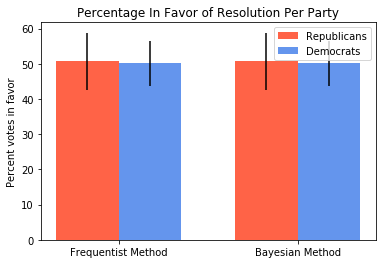

In [51]:
rep_means = []
rep_error = []
dem_means = []
dem_error = []

header = 'water-project-cost-sharing'

mean, error = confidence_interval(rep[header].dropna())
rep_means.append(mean*100)
rep_error.append(error*100)

mean, error = confidence_interval(dem[header].dropna())
dem_means.append(mean*100)
dem_error.append(error*100)

bayesian_confidence_interval, _, _ = stats.bayes_mvs(rep[header].dropna(), alpha=0.95)
mean, minmax = bayesian_confidence_interval
min, max = minmax
error = max - mean
rep_means.append(mean*100)
rep_error.append(error*100)

bayesian_confidence_interval, _, _ = stats.bayes_mvs(dem[header].dropna(), alpha=0.95)
mean, minmax = bayesian_confidence_interval
min, max = minmax
error = max - mean
dem_means.append(mean*100)
dem_error.append(error*100)

labels = ['Frequentist Method', 'Bayesian Method']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, rep_means, width, yerr=rep_error, label='Republicans', color='tomato')
rects2 = ax.bar(x + width/2, dem_means, width, yerr=dem_error, label='Democrats', color='cornflowerblue')

ax.set_ylabel('Percent votes in favor')
ax.set_title('Percentage In Favor of Resolution Per Party')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend();


# Difference between Frequentist and Bayesian statistics

In the XKCD comic shown during the lecture, we're introduced to a machine that measures if the sun has exploded, and then rolls two dice. If both dice come up 6, it tells the truth. 

Upon the machine saying that the sun has exploded, the Frequentist calculates the probibility of both dice being rolled as a 'six', comes up with a p value based off of this, and assumes that the sun has exploded. They made their assesment entirely on the frequency of a false positive, assuming the sun has actually blown up. 

The Bayesian, however, takes into account the statistical unlikelyhood of the sun exploding, the chance of which is astronomically smaller than rolling a six on two dice. That is to say, the Bayesian method takes into account not only the chance of getting a false positive, but the chance of the test being truly positive at all. 



## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!